<style>
.text_cell_render {
font-family: Times New Roman, serif;
}
</style>

This Jupyter notebook is a supplementary file to the paper: From long-lived batholith construction to giant porphyry copper deposit formation: petrological and zircon chemical evolution of the Quellaveco District, Southern Peru, by *Chetan L. Nathwani, Adam T. Simmons, Simon J. E. Large, Jamie J. Wilkinson, Yannick Buret, Christian Ihlenfeld*
 

# Import packages and define functions

In [3]:
import math as m
import numpy as np
import pandas as pd
import random as rd
import seaborn as sb
import statistics as st
from scipy.stats import norm
import scipy as scipy
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)
from pylab import rcParams # for plotting parameters
rcParams['figure.figsize'] = 5,5
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale


%matplotlib inline


# Set and check working directory
%cd C:\Users\chen\Documents\NHM BACKUP\Documents\PhD\Python Projects\Zircon_Modelling
%pwd

C:\Users\chen\Documents\NHM BACKUP\Documents\PhD\Python Projects\Zircon_Modelling


'C:\\Users\\chen\\Documents\\NHM BACKUP\\Documents\\PhD\\Python Projects\\Zircon_Modelling'

In [4]:
# Define a function that calcualtes the concentration of an element in a mineral
def calculate_Cmin(Cmelt, bulk_D):
    return Cmelt * bulk_D

# Define a function that calculates the partition coefficient of Eu in a mineral using Aigner Torres et al. (2007)
def calculate_DEu(DEu3, DEu2, Eu2Eu3melt):
    return (DEu3 + (Eu2Eu3melt * DEu2))/(Eu2Eu3melt + 1)

# Define a function that calculates DEu3
def calculate_DEu3(Sm, Gd):
    return m.sqrt(Sm*Gd)

# Function for Eu3+/Eutotal in a melt from Burnham paper
def Eu3Eutotal (logfO2, T, opt_bas):
    return 1/(1+10**(-0.25*logfO2-(6410/T)-(14.2*opt_bas)+10.1))

# Calculate Eu/Eu* norm
def Eu_anomaly (Sm, Eu, Gd):
    return (Eu/0.058)/m.sqrt((Sm/0.153)*(Gd/0.2055))

# Calculate the Eu anomaly in zircon based on the D value for Eu3+ and Eu/Eu* melt
def Eu_anomaly_zircon(Eu_anomaly_melt, DEu3):
    return Eu_anomaly_melt*DEu3

# Convert logfO2 to del FMQ
def calculate_delFMQ(logfO2, T):
    return logfO2 + (24441.9/T) - 8.29

def calculate_logfO2(delFMQ, T):
    return delFMQ + 8.29 - (24441.9/T)

# Calculate Eu2+/Eu3+ using Burnham et al. (2015) experimental calibration

def calculate_Eu2Eu3ratio(logfO2, T, opt_bas):
    return 10**(-0.25*logfO2-(6410/T)-(14.2*opt_bas)+10.1)

# Rearranged Eu anomaly Eq
def calculate_Eu(Eu_anomaly, Sm, Gd):
    return Eu_anomaly*(m.sqrt((Sm/0.153)*(Gd/0.2055)))*0.058

# Use Blundy and Wood (1984)
def calculate_lattice_strain(T, ri, r0, E, D0):
    Di = D0*np.exp((-4*np.pi*E*(6.02214086e23)*((r0/2)*(r0-ri)**2-((1/3)*(r0-ri)**3)))/(8.314*T))
    return(Di)

# Calculating ranges for mineral-melt partition coefficients for Eu\textsuperscript{2+}, Eu\textsuperscript{3+}, Sm and Gd

Partition coefficients for Sm, Eu\textsuperscript{3+} and Gd are estimated using lattice strain theory (Blundy and Wood 1994) where the best fit parameters for the Onuma curves are compiled from literature sources (see Table 1.3 in Claiborne et al. 2017). D(Eu\textsuperscript{2+}) is assumed to be 0 based on its low charge and mismatch cation size.

D\textsubscript{0} is expected to be strongly temperature dependent and is therefore varied as a function of temperature. The Young's Modulus (E\textsubscript{M}) and site radius (r\textsubscript{0}) are varied in tandem based on relationships in the best fit parameters (see Fig. 1 in Burnham 2020).

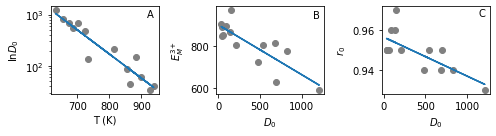

In [5]:
# Import lattice strain parameters from Claiborne et al.2017 
zircon_LS = pd.read_csv('Claiborne2017_Zircon_LatticeStrain.csv')
zircon_LS = zircon_LS.drop(11, axis = 0) # remove IIKK outlier at index 11

# Generate figure axes
rcParams['figure.figsize'] = 7,2
fig, axs = plt.subplots(1,3)


p1 = np.polyfit(zircon_LS['T'], np.log(zircon_LS['D0']), 1) # fit least squares
y = []
for i in zircon_LS['T']:
    i = np.exp((i * p1[0]) + p1[1])
    y.append(i)
axs[0].scatter(x = zircon_LS['T'], y = zircon_LS['D0'], c = 'grey')
axs[0].set_xlabel('T (K)')
axs[0].set_ylabel('ln$D_{0}$')
axs[0].plot(zircon_LS['T'], y, '-')
axs[0].set_yscale('log')
axs[0].annotate('A', (940,900), ha='right')

p2 = np.polyfit(zircon_LS['D0'], zircon_LS['Em3+'], 1) # fit least squares
axs[1].scatter(x = zircon_LS['D0'], y = zircon_LS['Em3+'], c = 'grey')
y = []
for i in zircon_LS['D0']:
    i = (i * p2[0]) + p2[1]
    y.append(i)
axs[1].plot(zircon_LS['D0'], y, '-')
axs[1].set_xlabel('$D_{0}$')
axs[1].set_ylabel('$E_{M}^{3+}$')
axs[1].annotate('B', (1220,930), ha='right')

p3 = np.polyfit(zircon_LS['D0'], zircon_LS['ro3+'], 1) # fit least squares
axs[2].scatter(x = zircon_LS['D0'], y = zircon_LS['ro3+'], c = 'grey')
y = []
for i in zircon_LS['D0']:
    i = (i * p3[0]) + p3[1]
    y.append(i)
axs[2].plot(zircon_LS['D0'], y, '-')
axs[2].set_xlabel('$D_{0}$')
axs[2].set_ylabel('$r_{0}$')
axs[2].annotate('C', (1220,0.967), ha='right')
fig.tight_layout()

plt.savefig('Lattice_Strain_Fit_Parameters_Zircon.png', dpi = 1200)

# Function to generate lattice strain parameters:

def calculate_LS_parameters(temperature):
    D0 = np.exp((temperature * p1[0]) + p1[1]) # partition coefficient of known
    Em3 = ((D0 * p2[0]) + p2[1])*(10**9) # Young's modulus
    r0 = ((D0 * p3[0]) + p3[1])*(10**-10) # radius of site
    return(D0, Em3, r0)

ri = [1.079, 1.066, 1.053] # Ionic Radii of Sm, Eu3+ and Gd (Shannon 1976)
ri = [i * 10**-10 for i in ri] # convert to metres

In [6]:
# Import whole-rock Sm, Gd and Eu composition spreadsheets using pandas
AllWR = pd.read_csv("AllWRSmEuGd.csv")

# Calculate Eu anomalies for the whole-rock compositions
All_Eu_anomalies = []
for i, j, k in zip(AllWR.iloc[:,2], AllWR.iloc[:,3], AllWR.iloc[:,4]):
    calculated_Eu_anomaly = Eu_anomaly(i , j, k)
    All_Eu_anomalies.append(calculated_Eu_anomaly)
    

# Calculating (Eu/Eu\*)\textsubscript{zircon} as a function of (Eu/Eu\*)\textsubscript{melt}

- The range of whole-rock Sm, Eu and Gd values from this study are used as input Eu/Eu* values for this. Since these values do not span to the low (Eu/Eu\*)\textsubscript{melt} neccessary for this model a linear regression is used to extrapolate to lower values
- Once the (Eu/Eu\*)\textsubscript{zircon} have been calculated as a function of (Eu/Eu\*)\textsubscript{melt}, we can use this relationship to extract the (Eu/Eu\*)\textsubscript{melt} that is in equilibrium with the zircons for the oldest Yarabamba batholith rocks and for the Quellaveco porphyry rocks
- The 95% confidence intervals for these (Eu/Eu\*)\textsubscript{melt} for early Yarabamba and Quellaveco porphyries are then used in the next stage of the model to test the effect of *f*O\textsubscript{2}


In [7]:
LinReg = LinearRegression()

WRSm, WREu, WRGd = np.array(AllWR.iloc[:,2]), np.array(AllWR.iloc[:,3]), np.array(AllWR.iloc[:,4])
WRSm_mean, WRSm_stdev = np.mean(WRSm), np.std(WRSm)
WRSm_min, WRSm_max = np.min(WRSm), np.max(WRSm)
extendedWRSm_max = WRSm_max*1
random_WREu_anomaly = np.random.uniform(0.1, 1.2, 1000) # Generate range of Eu anomaly melt
random_WREu_anomaly = np.reshape(random_WREu_anomaly, (-1, 1)) # reshape to 2d array

# Set up LinReg model
WRSm = np.reshape(WRSm, (-1,1))
WRGd = np.reshape(WRGd, (-1,1))
WREu_anomaly = np.reshape(All_Eu_anomalies, (-1,1))
LinReg.fit(WREu_anomaly, WRSm)
WRSm_pred = LinReg.predict(random_WREu_anomaly)
LinReg.fit(WREu_anomaly, WRGd)
WRGd_pred = LinReg.predict(random_WREu_anomaly)

# now calculate Eu values:

WRGd_pred = np.sort(np.ravel(WRGd_pred))
WRSm_pred = np.sort(np.ravel(WRSm_pred))
random_WREu_anomaly = np.sort(np.ravel(random_WREu_anomaly))

WREu_pred = []
for i, j, k in zip(random_WREu_anomaly, WRSm_pred, WRGd_pred):
    Eu_pred = calculate_Eu(i, j, k)
    WREu_pred.append(Eu_pred)
    
WREu_pred = np.random.uniform(np.min(WREu_pred), np.max(WREu_pred), 1000)

random_AllWR = [WRSm_pred, WREu_pred, WRGd_pred]

Optical basicity is varied with temperature by calculating theoretical optical basicity using Duffy (1993) for the experimental runs of Marxer and Ulmer (2019)

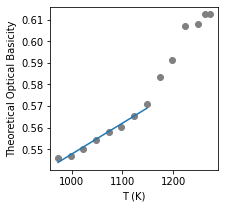

In [8]:
rcParams['figure.figsize'] = 3,3
Marxer_Ulmer = pd.read_csv('MarxerUlmer_T_opt.csv')
Marxer_Ulmer['opt_bas'] = (Marxer_Ulmer['Si']*0.48)+(Marxer_Ulmer['Al']*0.6)+(Marxer_Ulmer['Mg'])+(Marxer_Ulmer['Mn']*0.78)+(Marxer_Ulmer['Fe']*1)+(Marxer_Ulmer['Ca']*1)+(Marxer_Ulmer['Na']*1.15)+(Marxer_Ulmer['K']*1.4)
y = []
Marxer_Ulmer['T'] = Marxer_Ulmer['T'] + 273.15
plt.scatter(x = Marxer_Ulmer['T'], y = Marxer_Ulmer['opt_bas'], c = 'grey')
Marxer_Ulmer = Marxer_Ulmer[Marxer_Ulmer['T'] < (890+273.15)]# Remove values greater with T outside of range appropriate
p4 = np.polyfit(Marxer_Ulmer['T'], Marxer_Ulmer['opt_bas'], 1) # fit least squares
for i in Marxer_Ulmer['T']:
    i = (i * p4[0]) + p4[1]
    y.append(i)
plt.plot(Marxer_Ulmer['T'], y, '-')
plt.xlabel('T (K)')
plt.ylabel('Theoretical Optical Basicity')
fig.tight_layout()
plt.savefig('OpticalBasicity_Temperature.png', dpi = 1200, bbox_inches = "tight")

def calculate_opt_bas(T):
    opt_bas = (T * p4[0]) + p4[1]
    return opt_bas

# Setting up and running a Monte Carlo simulation

- We want to calculate 10,000 results for (Eu/Eu\*)\textsubscript{zircon} through varying all parameters in the model randomly within reasonable limits
- We then want to assess the effect (Eu/Eu\*)\textsubscript{melt} is having on (Eu/Eu\*)\textsubscript{zircon} (relative to other variables)
- Finally, use the measured (Eu/Eu\*)\textsubscript{zircon} in the Yarabamba and Quellaveco units to estimate what the (Eu/Eu\*)\textsubscript{melt} was that is in equilbirium with the natural zircons

0.2614248530037876 0.1340229904654482
0.4689286556973786 0.40544871763262674
0.24019183550583717 0.14526802228129926
0.6762113588250804 0.14526802228129926


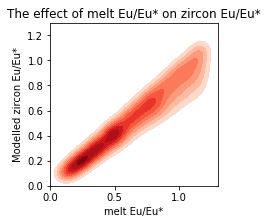

In [9]:
# Set ranges for T and fO2 for the first model Monte Carlo simulation
fO2_max = 3
fO2_min = 0
T_max, T_min = 880, 700
T_max, T_min = T_max + 273.15, T_min + 273.15
# Create array of 1000 random observations
random_T = np.random.uniform(T_max, T_min, 1000)
random_fO2 = np.random.uniform(fO2_max, fO2_min, 1000)

# Monte Carlo Simulation
max_simulations = 10000
number_of_simulations = 0
master_list_All = []
master_Eu_anomalies_All = []
All_master_fO2 = []
master_melt_Eu_All = []
master_melt_Sm_All = []
master_melt_Gd_All = []
while number_of_simulations < max_simulations:
    element = 0 # reset element number back to lanthanum
    element_melt_comp = [] # reset empty list
    rd_T = rd.choice(random_T)
    rd_fO2 = rd.choice(random_fO2)
    rd_fO2 = calculate_logfO2(rd_fO2, rd_T)
    rd_opt_bas = calculate_opt_bas(rd_T)
    rd_Eu2Eu3 = calculate_Eu2Eu3ratio(rd_fO2, rd_T, rd_opt_bas)
    D0, Em3, r0 = calculate_LS_parameters(rd_T)
    rd_DSm = calculate_lattice_strain(rd_T, ri[0], r0, Em3, D0)
    rd_DEu3 = calculate_lattice_strain(rd_T, ri[1], r0, Em3, D0)
    rd_DGd = calculate_lattice_strain(rd_T, ri[2], r0, Em3, D0)
    rd_DEu = calculate_DEu(rd_DEu3, 0, rd_Eu2Eu3)
    delFMQ = calculate_delFMQ(rd_fO2, rd_T)
    index = rd.randrange(len(random_WREu_anomaly))
    allSm = random_AllWR[0]
    allGd = random_AllWR[2]
    Sm = allSm[index]
    Gd = allGd[index]
    SmGd_melt_comp = []
    Eu_anomaly_melt = random_WREu_anomaly[index]
    Eu = calculate_Eu(Eu_anomaly_melt, Sm, Gd)
    Sm_min = calculate_Cmin(Sm, rd_DSm)
    Eu_min = calculate_Cmin(Eu, rd_DEu)
    Gd_min = calculate_Cmin(Gd, rd_DGd)
    zircon_Eu_anomaly = Eu_anomaly(Sm_min, Eu_min, Gd_min)
    master_Eu_anomalies_All.append(zircon_Eu_anomaly)
    All_master_fO2.append(delFMQ)
    master_melt_Eu_All.append(Eu_anomaly_melt)
    master_melt_Sm_All.append(Sm)
    master_melt_Gd_All.append(Gd)
    number_of_simulations = number_of_simulations + 1


# Import natural compositions

Zircon_Eu_Yarabamba = pd.read_csv("YarabambaSmEuGdZircon.csv")
Zircon_Eu_Porphyry = pd.read_csv("PorphyrySmEuGdZircon.csv")

Zircon_Eu_Yarabamba = np.single(Zircon_Eu_Yarabamba.iloc[:, 1:].to_numpy()) # convert to a numpy array and to floats, iloc to remove the sample name column
Zircon_Eu_Porphyry = np.single(Zircon_Eu_Porphyry.iloc[:, 1:].to_numpy())
yarabamba_Eu_natural = []
# calculate Eu anomalies
for i in Zircon_Eu_Yarabamba:
    Eu_star = Eu_anomaly(i[0], i[1], i[2])
    yarabamba_Eu_natural.append(Eu_star)
porphyry_Eu_natural = []
# calculate Eu anomalies
for i in Zircon_Eu_Porphyry:
    Eu_star = Eu_anomaly(i[0], i[1], i[2])
    porphyry_Eu_natural.append(Eu_star)

yar_q75, yar_q25 = np.percentile(yarabamba_Eu_natural, [75 ,25])
yarabamba_Eu_melt_calculated = []
yarabamba_Sm_melt_calculated = []
yarabamba_Gd_melt_calculated = []
yarabamba_Eu_anomaly_melt_calculated = []
for i, j, k, l in zip(master_Eu_anomalies_All, master_melt_Eu_All, master_melt_Sm_All, master_melt_Gd_All):
    if i < yar_q75 and i > yar_q25:
            yarabamba_Eu_melt_calculated.append(j) # Eu anomaly
            yarabamba_Sm_melt_calculated.append(k)
            yarabamba_Gd_melt_calculated.append(l)
            yarabamba_Eu_anomaly_melt_calculated.append(j)

# Filter out so the extreme 5% values are removed from the calculated melts
yar_calculated_q95, yar_calculated_q5 = np.percentile(yarabamba_Eu_anomaly_melt_calculated, [95, 5])
yar_Sm = []
yar_Euanom = []
yar_Gd = []
for i, j, k in zip (yarabamba_Eu_anomaly_melt_calculated, yarabamba_Sm_melt_calculated, yarabamba_Gd_melt_calculated):
    if i < yar_calculated_q95 and i > yar_calculated_q5:
        yar_Euanom.append(i)
        yar_Sm.append(j)
        yar_Gd.append(k)
yarabamba_Eu_anomaly_melt_calculated = yar_Euanom
yarabamba_Sm_melt_calculated = yar_Sm
yarabamba_Gd_melt_calculated = yar_Gd

# Find interquartile range
por_q75, por_q25 = np.percentile(porphyry_Eu_natural, [75 ,25])
print(por_q75, por_q25)
porphyry_Eu_melt_calculated = []
porphyry_Sm_melt_calculated = []
porphyry_Gd_melt_calculated = []
porphyry_Eu_anomaly_melt_calculated = []
for i, j, k, l in zip(master_Eu_anomalies_All, master_melt_Eu_All, master_melt_Sm_All, master_melt_Gd_All):
    if i < por_q75 and i > por_q25:
        porphyry_Eu_melt_calculated.append(j) # Eu anomaly
        porphyry_Sm_melt_calculated.append(k)
        porphyry_Gd_melt_calculated.append(l)
        porphyry_Eu_anomaly_melt_calculated.append(j)

# Filter out so the extreme 5% values are removed from the calculated melts 
por_calculated_q95, por_calculated_q5 = np.percentile(porphyry_Eu_anomaly_melt_calculated, [95, 5])
por_Sm = []
por_Euanom = []
por_Gd = []
for i, j, k in zip (porphyry_Eu_anomaly_melt_calculated, porphyry_Sm_melt_calculated, porphyry_Gd_melt_calculated):
    if i < por_calculated_q95 and i > por_calculated_q5:
        por_Euanom.append(i)
        por_Sm.append(j)
        por_Gd.append(k)
porphyry_Eu_anomaly_melt_calculated = por_Euanom
porphyry_Sm_melt_calculated = por_Sm
porphyry_Gd_melt_calculated = por_Gd

yar_calculated_q95, yar_calculated_q5 = np.percentile(yarabamba_Eu_anomaly_melt_calculated, [95, 5])
yar_Sm = []
yar_Euanom = []
yar_Gd = []
for i, j, k in zip (yarabamba_Eu_anomaly_melt_calculated, yarabamba_Sm_melt_calculated, yarabamba_Gd_melt_calculated):
    if i < yar_calculated_q95 and i > yar_calculated_q5:
        yar_Euanom.append(i)
        yar_Sm.append(j)
        yar_Gd.append(k)
yarabamba_Eu_anomaly_melt_calculated = yar_Euanom
yarabamba_Sm_melt_calculated = yar_Sm
yarabamba_Gd_melt_calculated = yar_Gd


all_Eu_melt_calculated = []
all_Sm_melt_calculated = []
all_Gd_melt_calculated = []
all_Eu_anomaly_melt_calculated = []
for i, j, k, l in zip(master_Eu_anomalies_All, master_melt_Eu_All, master_melt_Sm_All, master_melt_Gd_All):
    if i < por_calculated_q95 and i > yar_calculated_q5:
        all_Eu_melt_calculated.append(j) # Eu anomaly
        all_Sm_melt_calculated.append(k)
        all_Gd_melt_calculated.append(l)
        all_Eu_anomaly_melt_calculated.append(i)
        

# Plot modelled Eu/Eu* zircon as a function of melt Eu/Eu*
ax = sb.kdeplot(master_melt_Eu_All, master_Eu_anomalies_All, shade=True, alpha=1, cmap='Reds')
ax.collections[0].set_alpha(0) # remove background colour
plt.xlabel('melt Eu/Eu*')
plt.ylim(0, 1.3)
plt.xlim(0, 1.3)
plt.ylabel("Modelled zircon Eu/Eu*")
plt.title('The effect of melt Eu/Eu* on zircon Eu/Eu*')
# plt.savefig('201117_VariedStartingComp.svg', format = 'svg', dpi = 1200)
plt.show()     

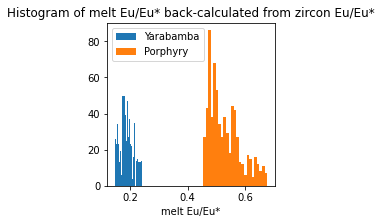

In [13]:
# Plot histograms for the obtained melts in equilbirium with the zircons
plt.hist(yarabamba_Eu_anomaly_melt_calculated, bins = 25, label = 'Yarabamba')
plt.hist(porphyry_Eu_anomaly_melt_calculated, bins = 25, label = 'Porphyry')
plt.xlabel('melt Eu/Eu*')
plt.title('Histogram of melt Eu/Eu* back-calculated from zircon Eu/Eu*')
plt.legend()
plt.show()

AllWR['Eu/Eu*'] = (AllWR['Eu']/0.058)/np.sqrt((AllWR['Sm']/0.153)*(AllWR['Gd']/0.2055))
AllWR["Blank"] = ""
yarabambaWR = AllWR.loc[AllWR['Age'] == 'Before 60 Ma']
porphyryWR =  AllWR.loc[AllWR['Age'] == 'After 60 Ma']


# Modelling the effect of melt *f*O\textsubscript{2} (and other parameters) on (Eu/Eu\*)\textsubscript{zircon}

- For the Yarabamba (Eu/Eu\*)\textsubscript{melt} populations calculated,(Eu/Eu\*)\textsubscript{zircon} is calculated with varying *f*O\textsubscript{2}, temperature, optical basicity and (Eu/Eu\*)\textsubscript{melt}.
- Separate models (10,000 simulations) are run for each parameters to isolate its effect.
- Increasing *f*O\textsubscript{2} within geologically feasible ranges cannot solely account for the change in (Eu/Eu\*)\textsubscript{zircon}.


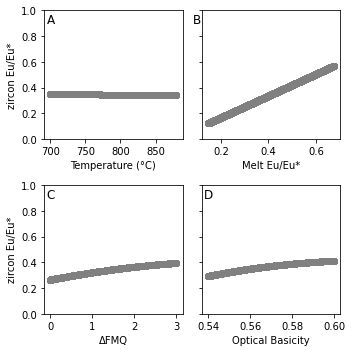

In [14]:
test_conditions = ['Temperature','Melt Eu/Eu*','fO2', 'Optical Basicity']
fig, axs = plt.subplots(2,2,figsize=(5,5))
axr = axs.flatten()
# Yarabamba estimated Eu melt composition, assess effect of fO2
test = 0
while test < len(test_conditions):
    max_simulations = 10000
    number_of_simulations = 0
    master_Eu_anomalies = []
    x_parameter = []
    while number_of_simulations < max_simulations:
        rd_fO2 = 1.5
        rd_T = 800+273.15
        rd_opt_bas = calculate_opt_bas(rd_T)
        # Change parameter to vary based on test run
        if test_conditions[test] == 'Temperature':
            rd_T = rd.choice(random_T)
        if test_conditions[test] == 'fO2':
            rd_fO2 = rd.choice(random_fO2)
        if test_conditions[test] == 'Optical Basicity':
            rd_opt_bas = rd.choice(np.random.uniform(0.60, 0.54, 1000))
        rd_fO2 = calculate_logfO2(rd_fO2, rd_T)
        rd_Eu2Eu3 = calculate_Eu2Eu3ratio(rd_fO2, rd_T, rd_opt_bas)
        D0, Em3, r0 = calculate_LS_parameters(rd_T)
        rd_DSm = calculate_lattice_strain(rd_T, ri[0], r0, Em3, D0)
        rd_DEu3 = calculate_lattice_strain(rd_T, ri[1], r0, Em3, D0)
        rd_DGd = calculate_lattice_strain(rd_T, ri[2], r0, Em3, D0)
        rd_DEu = calculate_DEu(rd_DEu3, 0, rd_Eu2Eu3)
        delFMQ = calculate_delFMQ(rd_fO2, rd_T)
        allSm = all_Sm_melt_calculated
        allGd = all_Gd_melt_calculated
        index = rd.randrange(len(all_Sm_melt_calculated))
        if test_conditions[test] == 'Melt Eu/Eu*':
            Sm = allSm[index]
            Gd = allGd[index]
            SmGd_melt_comp = []
            Eu_anomaly_melt = all_Eu_anomaly_melt_calculated[index]
        if test_conditions[test] != 'Melt Eu/Eu*':
            Sm = np.mean(allSm)
            Gd = np.mean(allGd)
            SmGd_melt_comp = []
            Eu_anomaly_melt = np.mean(all_Eu_anomaly_melt_calculated)
#         Eu_anomaly_melt = yarabamba_Eu_anomaly_melt_calculated[index]
        Eu = calculate_Eu(Eu_anomaly_melt, Sm, Gd)
        Sm_min = calculate_Cmin(Sm, rd_DSm)
        Eu_min = calculate_Cmin(Eu, rd_DEu)
        Gd_min = calculate_Cmin(Gd, rd_DGd)
        zircon_Eu_anomaly = Eu_anomaly(Sm_min, Eu_min, Gd_min)
        master_Eu_anomalies.append(zircon_Eu_anomaly)
        number_of_simulations = number_of_simulations + 1
        if test_conditions[test] == 'Temperature':
            rd_T = rd_T - 273.15
            x_parameter.append(rd_T)
        if test_conditions[test] == 'fO2':
            x_parameter.append(delFMQ)
        if test_conditions[test] == 'Melt Eu/Eu*':
            x_parameter.append(Eu_anomaly_melt)
        if test_conditions[test] == 'Optical Basicity':
            x_parameter.append(rd_opt_bas)
    axr[test].scatter(x_parameter, master_Eu_anomalies, c = 'grey')
    axr[test].set_ylim(0,1)
    test = test + 1

axr[0].set_ylabel('zircon Eu/Eu*')
axr[2].set_ylabel('zircon Eu/Eu*')
axr[0].text(695,0.9, 'A', ha='left', fontsize = '12')
axr[1].text(0.08,0.9, 'B', ha='left', fontsize = '12')
axr[2].text(-0.1,0.9, 'C', ha='left', fontsize = '12')
axr[3].text(0.538,0.9, 'D', ha='left', fontsize = '12')
axr[0].set_xlabel('Temperature (°C)')
axr[1].set_xlabel('Melt Eu/Eu*')
axr[2].set_xlabel('ΔFMQ')
axr[3].set_xlabel('Optical Basicity')
axr[1].set_yticklabels([])
axr[3].set_yticklabels([])

fig.tight_layout()
# plt.savefig('modelEuzircon_test_conditions.png', dpi = 1200)
plt.show()

# plt.savefig('201117_VariedStartingComp.svg', format = 'svg', dpi = 1200)
plt.show()     


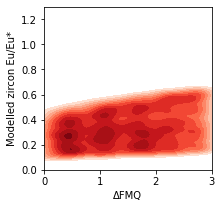

In [15]:
# Generate a heat map for fO2 vs zircon Eu/Eu*

# Monte Carlo Simulation
max_simulations = 10000
number_of_simulations = 0
master_list_All = []
master_Eu_anomalies_All = []
All_master_fO2 = []
master_melt_Eu_All = []
master_melt_Sm_All = []
master_melt_Gd_All = []
while number_of_simulations < max_simulations:
    element = 0 # reset element number back to lanthanum
    element_melt_comp = [] # reset empty list
    rd_T = rd.choice(random_T)
    rd_fO2 = rd.choice(random_fO2)
    rd_fO2 = calculate_logfO2(rd_fO2, rd_T)
    rd_opt_bas = calculate_opt_bas(rd_T)
    rd_Eu2Eu3 = calculate_Eu2Eu3ratio(rd_fO2, rd_T, rd_opt_bas)
    D0, Em3, r0 = calculate_LS_parameters(rd_T)
    rd_DSm = calculate_lattice_strain(rd_T, ri[0], r0, Em3, D0)
    rd_DEu3 = calculate_lattice_strain(rd_T, ri[1], r0, Em3, D0)
    rd_DGd = calculate_lattice_strain(rd_T, ri[2], r0, Em3, D0)
    rd_DEu = calculate_DEu(rd_DEu3, 0, rd_Eu2Eu3)
    delFMQ = calculate_delFMQ(rd_fO2, rd_T)
    index = rd.randrange(len(random_WREu_anomaly))
    allSm = all_Sm_melt_calculated
    allGd = all_Gd_melt_calculated
    index = rd.randrange(len(all_Sm_melt_calculated))
    Sm = allSm[index]
    Gd = allGd[index]
    SmGd_melt_comp = []
    Eu_anomaly_melt = all_Eu_anomaly_melt_calculated[index]
    Eu = calculate_Eu(Eu_anomaly_melt, Sm, Gd)
    Sm_min = calculate_Cmin(Sm, rd_DSm)
    Eu_min = calculate_Cmin(Eu, rd_DEu)
    Gd_min = calculate_Cmin(Gd, rd_DGd)
    zircon_Eu_anomaly = Eu_anomaly(Sm_min, Eu_min, Gd_min)
    master_Eu_anomalies_All.append(zircon_Eu_anomaly)
    All_master_fO2.append(delFMQ)
    master_melt_Eu_All.append(Eu_anomaly_melt)
    master_melt_Sm_All.append(Sm)
    master_melt_Gd_All.append(Gd)
    number_of_simulations = number_of_simulations + 1
    
ax = sb.kdeplot(All_master_fO2, master_Eu_anomalies_All, shade=True, alpha=1, cmap='Reds')
ax.collections[0].set_alpha(0) # remove background colour
plt.xlabel('ΔFMQ')
plt.ylim(0, 1.3)
plt.xlim(0, 3)
plt.ylabel("Modelled zircon Eu/Eu*")
# plt.savefig('201130_VariedfO2.svg', format = 'svg', dpi = 1200)
plt.show()    